#Descrizione

Test di dtype utilizzati. Carico le immagini come uint16 (dimezzando il peso nativo), creo il database, faccio lo shuffle, lo divido; nel fare la normalizzazione nel range 0-1, il dtype ritorna quello originale: faccio il cast a float32 (il più piccolo float utilizzabile) e la memoria occupata dimezza.

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [2]:
import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

import cv2

#Data visualization
import seaborn as sns

from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, os.path

#Per modello NN
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dropout

import time
import math

print(tf.__version__)

1.15.2


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Defining methods

In [3]:
#Extract the class from the file name, if the class is the string before che -
def extract_label(from_string):
  position = from_string.index('-') # gets position of the - in the filename
  substring = from_string[0:position]
  return substring

def extract_obf(from_string):
  start_pos = from_string.index('-')
  end_pos = from_string.index('.')
  substring = from_string[(start_pos + 1):end_pos]
  return substring

def mapping_labels_encoded(label_encoder):
  for index in range(len(list(label_encoder.classes_))):
    print(index, end = "-> ")
    print(list(label_encoder.inverse_transform([index]))) 

class TimeHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


print("Done")

Done


#Import database

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
downloaded = drive.CreateFile({'id':"18ESID3MpwG-SzZPE1EENzsGPh8vl8ti9"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data_18800.zip')        # replace the file name with your file

In [6]:
!unzip -q data_18800.zip -d DB_Repo/

print("Done")

Done


In [7]:
path, dirs, files = next(os.walk("/content/DB_Repo/data"))
file_count = len(files)
#Should be 18800
print(file_count)

18800


In [8]:
%cd /content/DB_Repo/data
!pwd

/content/DB_Repo/data
/content/DB_Repo/data


##Lettura database e resize immagini

In [59]:
batch_size = 2048

#Unit in first layer
num_units1 = 141

new_dim = 64
MAX_LEN = 64 #fisso
channels = 1

time_steps = new_dim
n_features = MAX_LEN
#size_ts_blocks = 8

n_epochs = 100

#Considero il primo 20% della lista di dati come test set
percentage_required = 20 #%

In [10]:
'''

#COSTANTI E DICHIARAZIONI

database_list = list()
labels_list = list()
obf_list = list()

#LETTURA E RESIZE IMMAGINI

import time

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype('float32') 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("float32")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")

database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.int32) 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("int32")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")

database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("originali")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")


database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.int16) 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("int16")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")


database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.uintc) 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("uintc")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")


database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.uint16) 
  dimStrana, _ = temp_img.shape
  #print("prima: ", temp_img.shape)
  if dimStrana <= 64:
    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > 64:
    temp_img = temp_img[0:64, 0:64]
  else:
    print("ERROR")
    quit()
  #print("dopo: ", temp_img.shape)
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")

end = time.time()
print(end - start)
print("uint16")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")

'''

'\n\n#COSTANTI E DICHIARAZIONI\n\ndatabase_list = list()\nlabels_list = list()\nobf_list = list()\n\n#LETTURA E RESIZE IMMAGINI\n\nimport time\n\nstart = time.time()\n\nprint("START IMAGE INPUT")\n#Aggiungo i valori alle liste leggendo i vari files\nfor filename in glob.glob(\'*.npy\'):\n  temp_img = np.load(filename)\n  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(\'float32\') \n  dimStrana, _ = temp_img.shape\n  #print("prima: ", temp_img.shape)\n  if dimStrana <= 64:\n    temp_img = np.pad(temp_img, ((0, 64 - dimStrana),(0,0)), mode=\'constant\',constant_values=0)\n  elif dimStrana > 64:\n    temp_img = temp_img[0:64, 0:64]\n  else:\n    print("ERROR")\n    quit()\n  #print("dopo: ", temp_img.shape)\n  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)\n  database_list.append(temp_img)\n  #Salvo la label, ossia la classe\n  labels_list.append(extract_label(filename))\n  #Salvo la lista di offuscatori di ogni file\n  obf_list.append(extract_obf(f

##Sulla precisione

Sui tipi: https://numpy.org/doc/stable/user/basics.types.html


Sull'half float type: https://en.wikipedia.org/wiki/Half-precision_floating-point_format

Potrei utilizzare half float come tipo (np.half / np.float16), ma potrei avere problemi di precisione (il massimo valore rappresentabile - minore di 1 - è 0.99951, il più piccolo valore, è 0.000000059605).

Utilizzando np.half, i risultati della rete neurale sono diversi, nella fattispecie 3 punti percentuale migliori, quindi si ha avuto una perdita di precisione nella rappresentazione di dati che ha influito il modello; meglio evitare tale dtype. 

NB: np.single occupa quanto np.float32.

In [11]:
'''
START IMAGE INPUT
END IMAGE INPUT
8.469525814056396
float32
308.0192 MB
START IMAGE INPUT
END IMAGE INPUT
8.201626062393188
int32
308.0192 MB
START IMAGE INPUT
END IMAGE INPUT
8.45319151878357
originali
616.0384 MB
START IMAGE INPUT
END IMAGE INPUT
8.074562311172485
int16
154.0096 MB
START IMAGE INPUT
END IMAGE INPUT
8.221441507339478
uintc
308.0192 MB
START IMAGE INPUT
END IMAGE INPUT
8.059799671173096
uint16
154.0096 MB
'''

'\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.469525814056396\nfloat32\n308.0192 MB\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.201626062393188\nint32\n308.0192 MB\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.45319151878357\noriginali\n616.0384 MB\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.074562311172485\nint16\n154.0096 MB\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.221441507339478\nuintc\n308.0192 MB\nSTART IMAGE INPUT\nEND IMAGE INPUT\n8.059799671173096\nuint16\n154.0096 MB\n'

In [79]:
database_list = list()
labels_list = list()
obf_list = list()

start = time.time()

#LETTURA E RESIZE IMMAGINI

sem = True

print("START IMAGE INPUT")
#Aggiungo i valori alle liste leggendo i vari files
for filename in glob.glob('*.npy'):
  temp_img = np.load(filename)
  temp_img = temp_img.reshape((-1, MAX_LEN)).astype(np.uint16) 
  dimStrana, _ = temp_img.shape
  if sem == True:
    print("prima: ", temp_img.shape)
  if dimStrana <= new_dim:
    temp_img = np.pad(temp_img, ((0, new_dim - dimStrana),(0,0)), mode='constant',constant_values=0)
  elif dimStrana > new_dim:
    temp_img = temp_img[0:new_dim, 0:64]
  else:
    print("ERROR")
    quit()
  if sem == True:
    print("dopo: ", temp_img.shape)
    sem = False
  #temp_img = cv2.resize(temp_img, (MAX_LEN, new_dim), interpolation=cv2.INTER_CUBIC)
  database_list.append(temp_img)
  #Salvo la label, ossia la classe
  labels_list.append(extract_label(filename))
  #Salvo la lista di offuscatori di ogni file
  obf_list.append(extract_obf(filename))
print("END IMAGE INPUT")



end = time.time()
print(end - start)
print("uint16")
print(database_list[0].nbytes * len(database_list) / 1000000, "MB")
print(database_list[0].shape)

START IMAGE INPUT
prima:  (131, 64)
dopo:  (64, 64)
END IMAGE INPUT
33.36968111991882
uint16
154.0096 MB
(64, 64)


In [80]:
#SHUFFLE

#Ho i valori e le etichette in due liste (+ obf); 
#le mescolo mantenendo l'ordine tra valore-label
temp = list(zip(database_list, labels_list, obf_list))
np.random.shuffle(temp)
database_list, labels_list, obf_list = zip(*temp)


#SUDDIVISIONE DATI

#Suddivido in training set e test set
assert len(database_list) == len(labels_list) == len(obf_list)

index_to_split = math.ceil((len(database_list) * percentage_required) / 100)
indices = [(0, index_to_split - 1), (index_to_split, len(database_list) - 1)]

test_list, training_list = [database_list[s:e+1] for s,e in indices]
labels_test_list, labels_training_list = [labels_list[s:e+1] for s,e in indices]
obf_test_list, obf_training_list = [obf_list[s:e+1] for s,e in indices]

#Trasformo i valori in numpy.ndarray
train_images = np.array(training_list)
test_images = np.array(test_list)

train_labels = np.array(labels_training_list)
test_labels = np.array(labels_test_list)

train_obf = np.array(obf_training_list)
test_obf = np.array(obf_test_list)

label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [81]:
train_images[0].shape

(64, 64)

In [82]:
#Normalizzazione valori in range 0-1
train_images = train_images / 65535.0
test_images = test_images / 65535.0

In [83]:
train_images[0].shape

(64, 64)

In [84]:
print(train_images[0].nbytes * len(train_images) / 1000000, "MB")

492.83072 MB


In [85]:
#train_images = train_images.reshape(-1, new_dim, MAX_LEN).astype(np.float32)
#test_images = test_images.reshape(-1, new_dim, MAX_LEN).astype(np.float32)

In [86]:
#print(train_images[0].nbytes * len(train_images) / 1000000, "MB")

In [87]:
#train_images[0].shape

In [88]:
train_images = train_images.reshape(-1, new_dim, MAX_LEN).astype(np.single)
test_images = test_images.reshape(-1, new_dim, MAX_LEN).astype(np.single)

In [89]:
print(train_images[0].nbytes * len(train_images) / 1000000, "MB")

246.41536 MB


In [90]:
train_images[0].shape

(64, 64)

In [91]:
#Dichiarazione parametri

n_classes = len(list(label_encoder.classes_))

modelLSTM = ks.Sequential()

#no activation selection

modelLSTM.add(Bidirectional(CuDNNLSTM(num_units1, unit_forget_bias='true', return_sequences='true'),
                            input_shape=(time_steps, n_features)))
modelLSTM.add(Bidirectional(CuDNNLSTM(94, unit_forget_bias='true')))
modelLSTM.add(Dense(n_classes, activation='softmax'))

modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Validation_data è usato al termine di ogni epoch;
#Batch size should be (at most) the same number of hidden cells
es = ks.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                mode='auto', restore_best_weights=True, verbose=1)
time_callback = TimeHistory()

hist = modelLSTM.fit(train_images, train_labels_encoded, 
                    batch_size = batch_size,
                    validation_data=(test_images, test_labels_encoded), 
                    epochs=n_epochs, shuffle='true',
                    callbacks=[time_callback, es], verbose=1)

number_of_epochs_it_ran = len(hist.history['loss'])

time_per_epoch = time_callback.times
total_time = sum(time_per_epoch)

Train on 15040 samples, validate on 3760 samples
Epoch 1/100
15040/15040 [==============================] - 3s 224us/sample - loss: 3.8150 - acc: 0.0456 - val_loss: 3.7331 - val_acc: 0.0750
Epoch 2/100
15040/15040 [==============================] - 2s 155us/sample - loss: 3.6839 - acc: 0.0703 - val_loss: 3.5842 - val_acc: 0.1104
Epoch 3/100
15040/15040 [==============================] - 2s 154us/sample - loss: 3.5052 - acc: 0.1182 - val_loss: 3.3701 - val_acc: 0.1231
Epoch 4/100
15040/15040 [==============================] - 2s 155us/sample - loss: 3.2955 - acc: 0.1462 - val_loss: 3.1253 - val_acc: 0.1891
Epoch 5/100
15040/15040 [==============================] - 2s 155us/sample - loss: 3.1051 - acc: 0.1824 - val_loss: 2.9818 - val_acc: 0.2104
Epoch 6/100
15040/15040 [==============================] - 2s 153us/sample - loss: 2.9316 - acc: 0.2229 - val_loss: 2.8512 - val_acc: 0.2402
Epoch 7/100
15040/15040 [==============================] - 2s 155us/sample - loss: 2.8176 - acc: 0.2433 -

In [92]:
test_accuracy = modelLSTM.evaluate(test_images, test_labels_encoded)

3760/3760 [==============================] - 1s 275us/sample - loss: 0.7006 - acc: 0.8306


In [93]:
print(str(total_time))

206.18330240249634


##Risultati

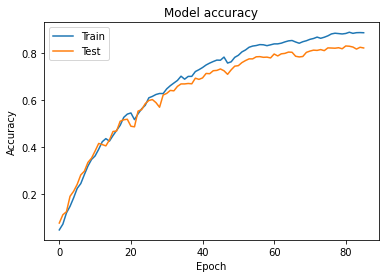

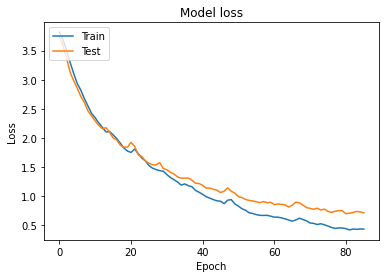

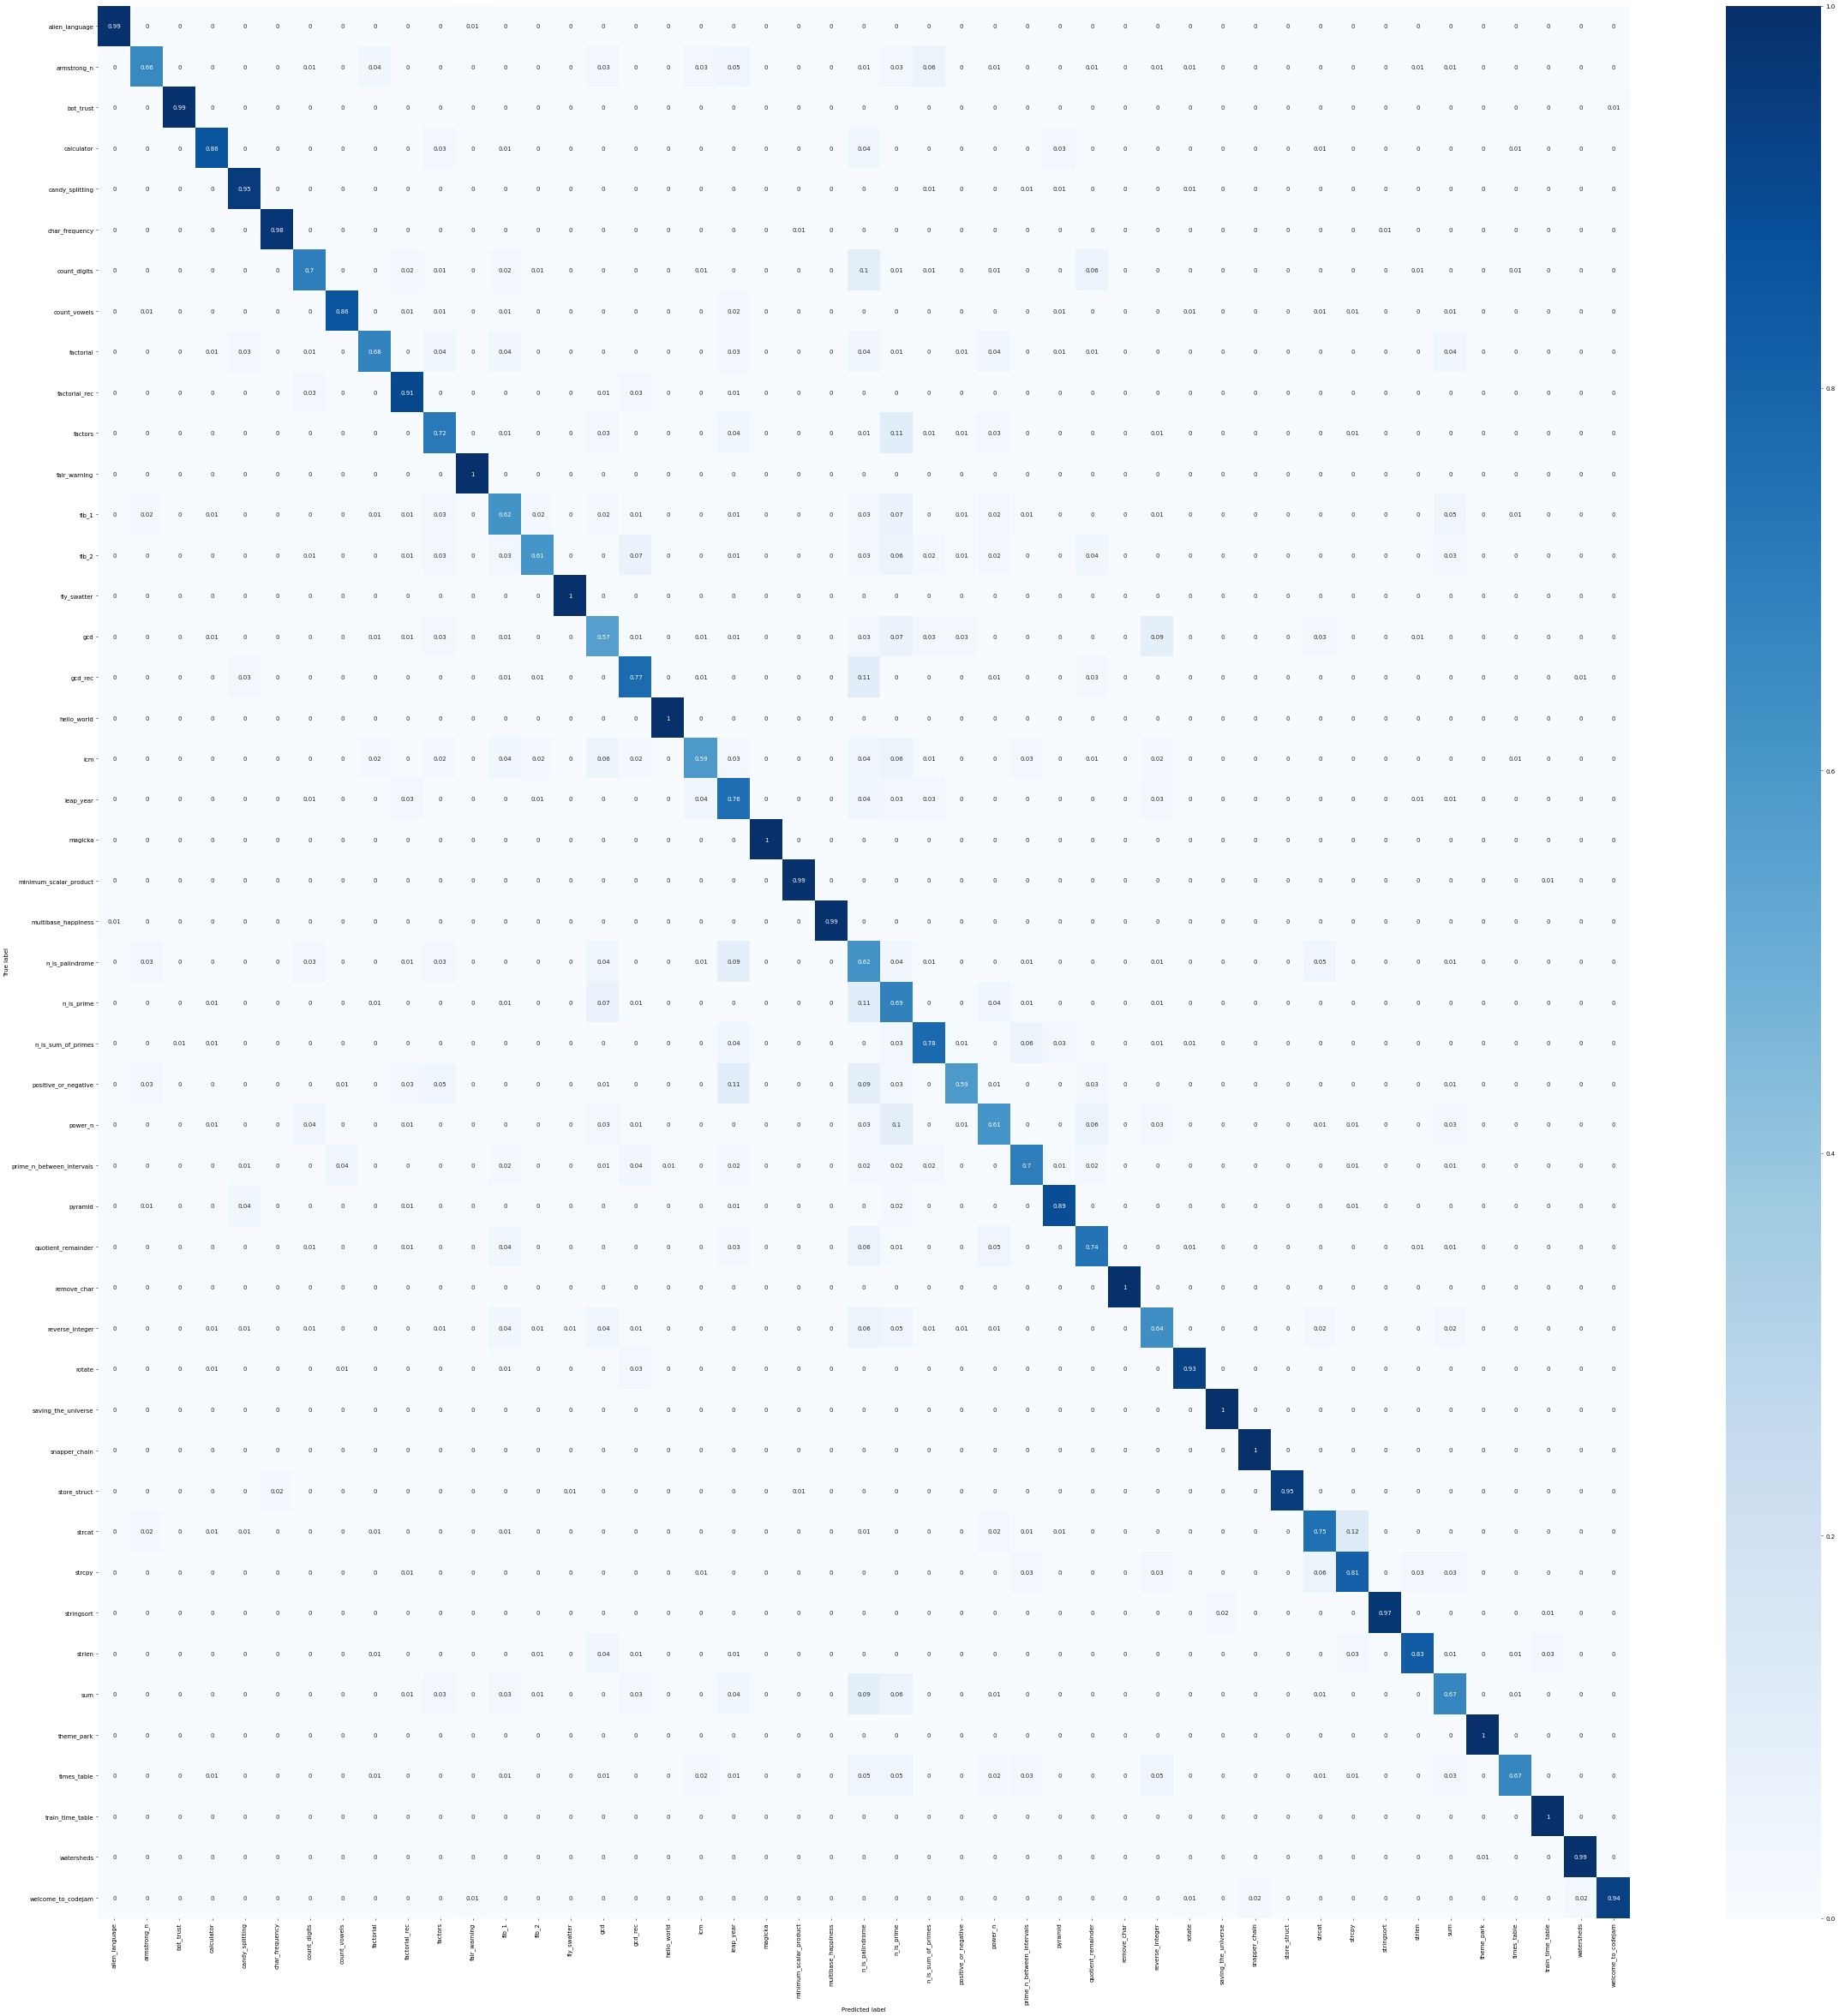

In [94]:
#Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#####

test_predictions = modelLSTM.predict_classes(test_images)

conf_matr = confusion_matrix(y_true = test_labels_encoded, y_pred = test_predictions)
#print(conf_matr)

con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                        index = list(label_encoder.classes_), 
                        columns = list(label_encoder.classes_))

figure = plt.figure(figsize=(len(list(label_encoder.classes_)), len(list(label_encoder.classes_))), dpi=50)
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#Analisi degli errori di classificazione

In [95]:
test_accuracy = modelLSTM.evaluate(test_images, test_labels_encoded)

3760/3760 [==============================] - 1s 292us/sample - loss: 0.7006 - acc: 0.8306


In [96]:
'''
for index in range(len(list(label_encoder.classes_))):
  #print(index, end = ": ")
  print(index, end = "-> ")
  print(label_encoder.inverse_transform([index]))
'''


#test_labels_encoded[3]
#array che contiene le etichette encoded.
#Ogni posizione ha un numero, e a quel numero corrisponde un'etichetta.
#Per esempio, il numero 0 corrisponde ad "alien_language".
#Per ogni 0 in test_labels_encoded, ci si riferisce a tale classe.



#modelLSTM.predict_classes(test_images)[3]
#Predict_classes fa una previsione su test_images.
#Genera un array di previsioni, dove per ogni test_images,
#genera una classe, ossia un numero.
#Se tale numero è giusto o meno, va verificato controllando le etichette corrispondenti.



#modelLSTM.predict_classes(test_images) != test_labels_encoded
#Genera un array di ogni elemento che non corrisponde alle test_labels_encoded
#Ossia genera un array di risultati predetti male.

'\nfor index in range(len(list(label_encoder.classes_))):\n  #print(index, end = ": ")\n  print(index, end = "-> ")\n  print(label_encoder.inverse_transform([index]))\n'

In [97]:
incorrects = np.nonzero(modelLSTM.predict_classes(test_images) != test_labels_encoded)
#Salvo in incorrects l'array di tutti gli elementi mal predetti
#Altra rappresentazione di incorrects
#incorrects = np.nonzero(modelLSTM.predict_classes(test_images).reshape((-1,)) != test_labels_encoded)

temp_incorrects = list()
for elem in incorrects[0]:
  #print(elem)
  temp_incorrects.append(elem)
incorrects = temp_incorrects
#Manipolo l'array delle previsioni scorrette affinchè sia una lista di valori
#Ogni valore è un numero, che indica il file del test_images sbagliato,
#Ossia ogni numero in incorrects è una classe mal indovinata

In [98]:
print(incorrects)
'''
Ogni elemento in incorrects è un numero;
tale numero indica i valori FALLITI all'interno del test set,
ossia, è fallito l'elemento 3, l'elemento 7, l'elemento 9 ecc.
Ogni elemento si riferisce ad una classe. La mappa la si ritrova con inverse_transform di label_encoder
'''

[1, 5, 11, 13, 16, 25, 36, 39, 49, 70, 92, 93, 95, 99, 121, 123, 128, 134, 136, 137, 146, 164, 169, 209, 219, 222, 224, 226, 228, 244, 249, 251, 256, 258, 259, 266, 268, 271, 278, 281, 296, 298, 300, 302, 303, 306, 323, 324, 354, 357, 364, 373, 382, 383, 395, 397, 399, 403, 407, 415, 425, 428, 430, 435, 436, 437, 443, 455, 460, 463, 465, 468, 471, 475, 487, 488, 492, 496, 497, 502, 504, 514, 515, 518, 522, 527, 535, 537, 542, 546, 550, 552, 556, 566, 568, 572, 576, 577, 588, 600, 622, 625, 626, 630, 631, 637, 639, 644, 654, 655, 656, 660, 670, 680, 681, 687, 701, 709, 719, 731, 734, 737, 743, 752, 753, 762, 763, 788, 799, 800, 801, 804, 813, 815, 817, 826, 827, 831, 832, 833, 834, 838, 839, 841, 846, 849, 852, 855, 876, 880, 883, 891, 901, 913, 933, 938, 939, 942, 949, 951, 952, 954, 955, 961, 968, 988, 993, 1005, 1008, 1010, 1011, 1017, 1019, 1025, 1032, 1033, 1035, 1036, 1046, 1048, 1053, 1054, 1055, 1058, 1064, 1078, 1079, 1087, 1096, 1097, 1098, 1111, 1121, 1127, 1144, 1146, 1147, 

"\nOgni elemento in incorrects è un numero;\ntale numero indica i valori FALLITI all'interno del test set,\nossia, è fallito l'elemento 3, l'elemento 7, l'elemento 9 ecc.\nOgni elemento si riferisce ad una classe. La mappa la si ritrova con inverse_transform di label_encoder\n"

In [99]:
wrong_labels_str = list()
#wrong_labels = list()
wrong_obf = list()
for elem in incorrects:
  '''
  Ogni elemento in incorrects, ossia ogni elem, è un numero.
  Tale numero indica quegli indici FALLITI all'interno del test set (test_labels_encoded).
  E' quindi un array di numeri, 3, 7, 9 ecc, ed ogni numero indica il file che ha fallito la previsione.

  Se 3, indica che il file 3 in test_labels_encoded ha FALLITO la previsione.
  Prelevo quel file da test_labels_encoded; se 3, test_labels_encoded[3] ritorna un intero,
  ossia l'encode della label corrispondente.
  '''
  string_to_append = str(label_encoder.inverse_transform([test_labels_encoded[elem]]))
  wrong_labels_str.append(string_to_append)
  #wrong_labels.append(test_labels_encoded[elem])
  ##########
  '''
  Al riguardo della lista degli offuscamenti, è più semplice.
  Se incorrects è una lista di previsioni fallite riportando l'indice della label,
  quell'indice, in obf_list, ritorna la lista corrispondente di offuscamenti.
  '''
  wrong_obf.append(obf_list[elem])

In [100]:
print(wrong_labels_str)
'''
Ogni elemento in wrong_labels è un numero;
tale numero indica i valori FALLITI all'interno del test set,
ossia, è fallito l'elemento 3, l'elemento 7, l'elemento 9 ecc.
'''
print(wrong_obf)

["['factorial']", "['strcpy']", "['calculator']", "['prime_n_between_intervals']", "['count_digits']", "['fib_2']", "['fib_1']", "['armstrong_n']", "['reverse_integer']", "['armstrong_n']", "['gcd_rec']", "['fib_2']", "['count_digits']", "['leap_year']", "['sum']", "['times_table']", "['fib_2']", "['n_is_sum_of_primes']", "['strlen']", "['positive_or_negative']", "['fib_2']", "['count_digits']", "['strcpy']", "['reverse_integer']", "['times_table']", "['leap_year']", "['gcd_rec']", "['prime_n_between_intervals']", "['times_table']", "['fib_1']", "['fib_1']", "['leap_year']", "['quotient_remainder']", "['sum']", "['count_digits']", "['count_vowels']", "['n_is_prime']", "['lcm']", "['quotient_remainder']", "['gcd']", "['fib_1']", "['gcd']", "['factorial']", "['factors']", "['lcm']", "['fib_2']", "['fib_2']", "['gcd']", "['positive_or_negative']", "['times_table']", "['sum']", "['sum']", "['fib_2']", "['leap_year']", "['power_n']", "['gcd']", "['leap_year']", "['quotient_remainder']", "['

In [101]:
print(len(wrong_labels_str))
print(len(wrong_obf))

assert len(wrong_labels_str) == len (wrong_obf)

637
637


In [102]:
from collections import Counter

count_labels_err = Counter(wrong_labels_str)
count_obf_err = Counter(wrong_obf)

In [103]:
count_labels_err

Counter({"['alien_language']": 1,
         "['armstrong_n']": 26,
         "['bot_trust']": 1,
         "['calculator']": 10,
         "['candy_splitting']": 4,
         "['char_frequency']": 2,
         "['count_digits']": 25,
         "['count_vowels']": 11,
         "['factorial']": 25,
         "['factorial_rec']": 6,
         "['factors']": 21,
         "['fib_1']": 33,
         "['fib_2']": 35,
         "['gcd']": 29,
         "['gcd_rec']": 17,
         "['lcm']": 37,
         "['leap_year']": 18,
         "['minimum_scalar_product']": 1,
         "['multibase_happiness']": 1,
         "['n_is_palindrome']": 29,
         "['n_is_prime']": 22,
         "['n_is_sum_of_primes']": 17,
         "['positive_or_negative']": 32,
         "['power_n']": 28,
         "['prime_n_between_intervals']": 24,
         "['pyramid']": 9,
         "['quotient_remainder']": 20,
         "['reverse_integer']": 29,
         "['rotate']": 5,
         "['store_struct']": 4,
         "['strcat']": 22,
 

In [104]:
count_obf_err

Counter({'EncodeArithmetic-EncodeLiterals-Flatten': 2,
         'EncodeArithmetic-EncodeLiterals-InitOpaque': 1,
         'EncodeArithmetic-EncodeLiterals-RandomFuns': 1,
         'EncodeArithmetic-EncodeLiterals-Split': 1,
         'EncodeArithmetic-Flatten-EncodeLiterals': 3,
         'EncodeArithmetic-Flatten-InitOpaque': 6,
         'EncodeArithmetic-Flatten-RandomFuns': 6,
         'EncodeArithmetic-Flatten-Split': 7,
         'EncodeArithmetic-InitEntropy-Flatten': 1,
         'EncodeArithmetic-InitEntropy-InitOpaque': 5,
         'EncodeArithmetic-InitImplicitFlow-InitOpaque': 4,
         'EncodeArithmetic-InitOpaque': 2,
         'EncodeArithmetic-InitOpaque-EncodeLiterals': 4,
         'EncodeArithmetic-InitOpaque-Flatten': 3,
         'EncodeArithmetic-InitOpaque-InitEntropy': 2,
         'EncodeArithmetic-InitOpaque-InitImplicitFlow': 3,
         'EncodeArithmetic-InitOpaque-RandomFuns': 4,
         'EncodeArithmetic-InitOpaque-Split': 2,
         'EncodeArithmetic-RandomFun

In [119]:
single_obfs = list()

for elem in wrong_obf:
  temp_list = elem.split('-')
  
  temp_list.sort()
  #print(temp_list)
  separator = '-'
  temp_list = separator.join(temp_list)
  #print(temp_list)
  single_obfs.append(temp_list)
  
  #for sub_elem in temp_list:
  #  single_obfs.append(sub_elem)

#count_single_obf = Counter(single_obfs)

In [137]:
count_ordered_single_obfs = Counter(single_obfs)
#count_ordered_single_obfs = count_ordered_single_obfs.most_common()

In [123]:
count_ordered_single_obfs

[('Flatten-RandomFuns-Split', 34),
 ('EncodeLiterals-InitOpaque-Split', 33),
 ('Flatten-InitOpaque-Split', 32),
 ('EncodeArithmetic-Flatten-RandomFuns', 29),
 ('EncodeArithmetic-InitEntropy-InitOpaque', 29),
 ('InitEntropy-InitOpaque-RandomFuns', 27),
 ('EncodeLiterals-Flatten-InitOpaque', 27),
 ('Flatten-InitEntropy-InitOpaque', 25),
 ('EncodeLiterals-RandomFuns-Split', 24),
 ('EncodeArithmetic-EncodeLiterals-InitOpaque', 22),
 ('EncodeArithmetic-InitOpaque-RandomFuns', 21),
 ('EncodeArithmetic-Flatten-Split', 20),
 ('EncodeLiterals-Flatten-Split', 20),
 ('EncodeArithmetic-Flatten-InitOpaque', 20),
 ('Flatten-InitImplicitFlow-InitOpaque', 19),
 ('InitEntropy-InitImplicitFlow-InitOpaque', 19),
 ('EncodeArithmetic-InitImplicitFlow-InitOpaque', 18),
 ('Flatten-InitOpaque-RandomFuns', 18),
 ('InitImplicitFlow-InitOpaque-RandomFuns', 17),
 ('EncodeArithmetic-RandomFuns-Split', 16),
 ('InitOpaque-RandomFuns-Split', 15),
 ('EncodeLiterals-InitOpaque-RandomFuns', 14),
 ('EncodeLiterals-InitEn

In [106]:
count_single_obf

Counter({'EncodeArithmetic': 208,
         'EncodeLiterals': 195,
         'Flatten': 274,
         'InitEntropy': 142,
         'InitImplicitFlow': 112,
         'InitOpaque': 438,
         'RandomFuns': 234,
         'Split': 231,
         'base': 6})

##Stampo grafi rapprensentanti gli errori di previsione

Stampa per etichetta erronea

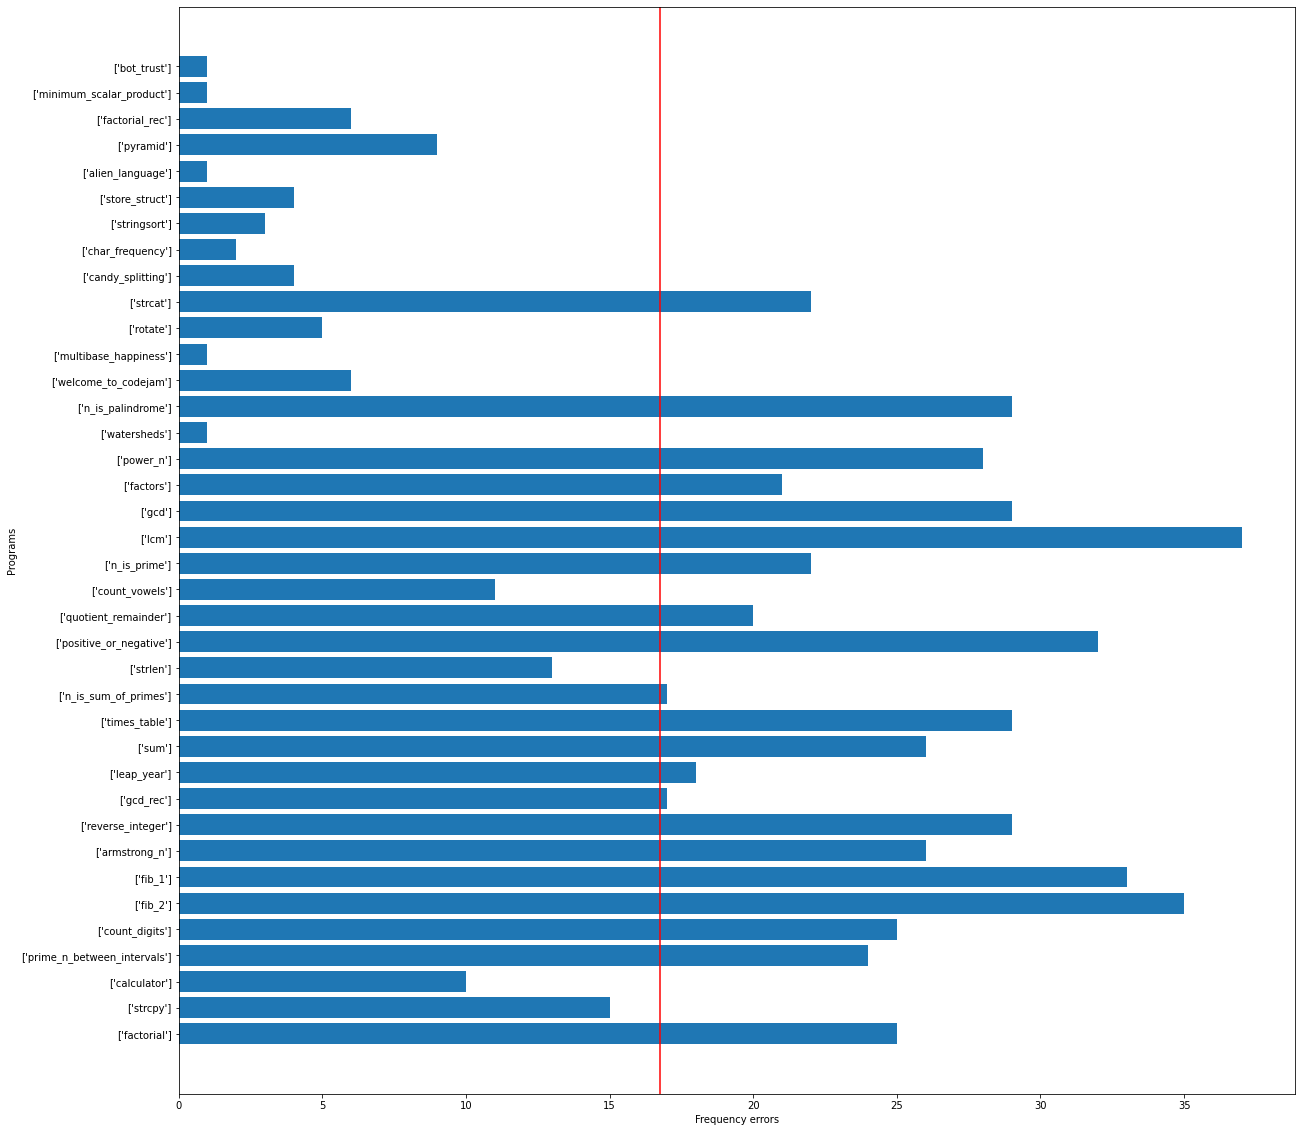

In [107]:
plt.figure(figsize=(20, 20))
plt.axvline(np.asarray(list(count_labels_err.values())).mean(), color="red") # Horizontal line adding the threshold
plt.barh(list(count_labels_err.keys()), list(count_labels_err.values()))

plt.xlabel("Frequency errors") # x label
plt.ylabel("Programs") # y label
plt.show()

In [108]:
#count_labels_err.keys()

In [109]:
#count_labels_err.values()

**Stampa per lista offuscamenti erronea**

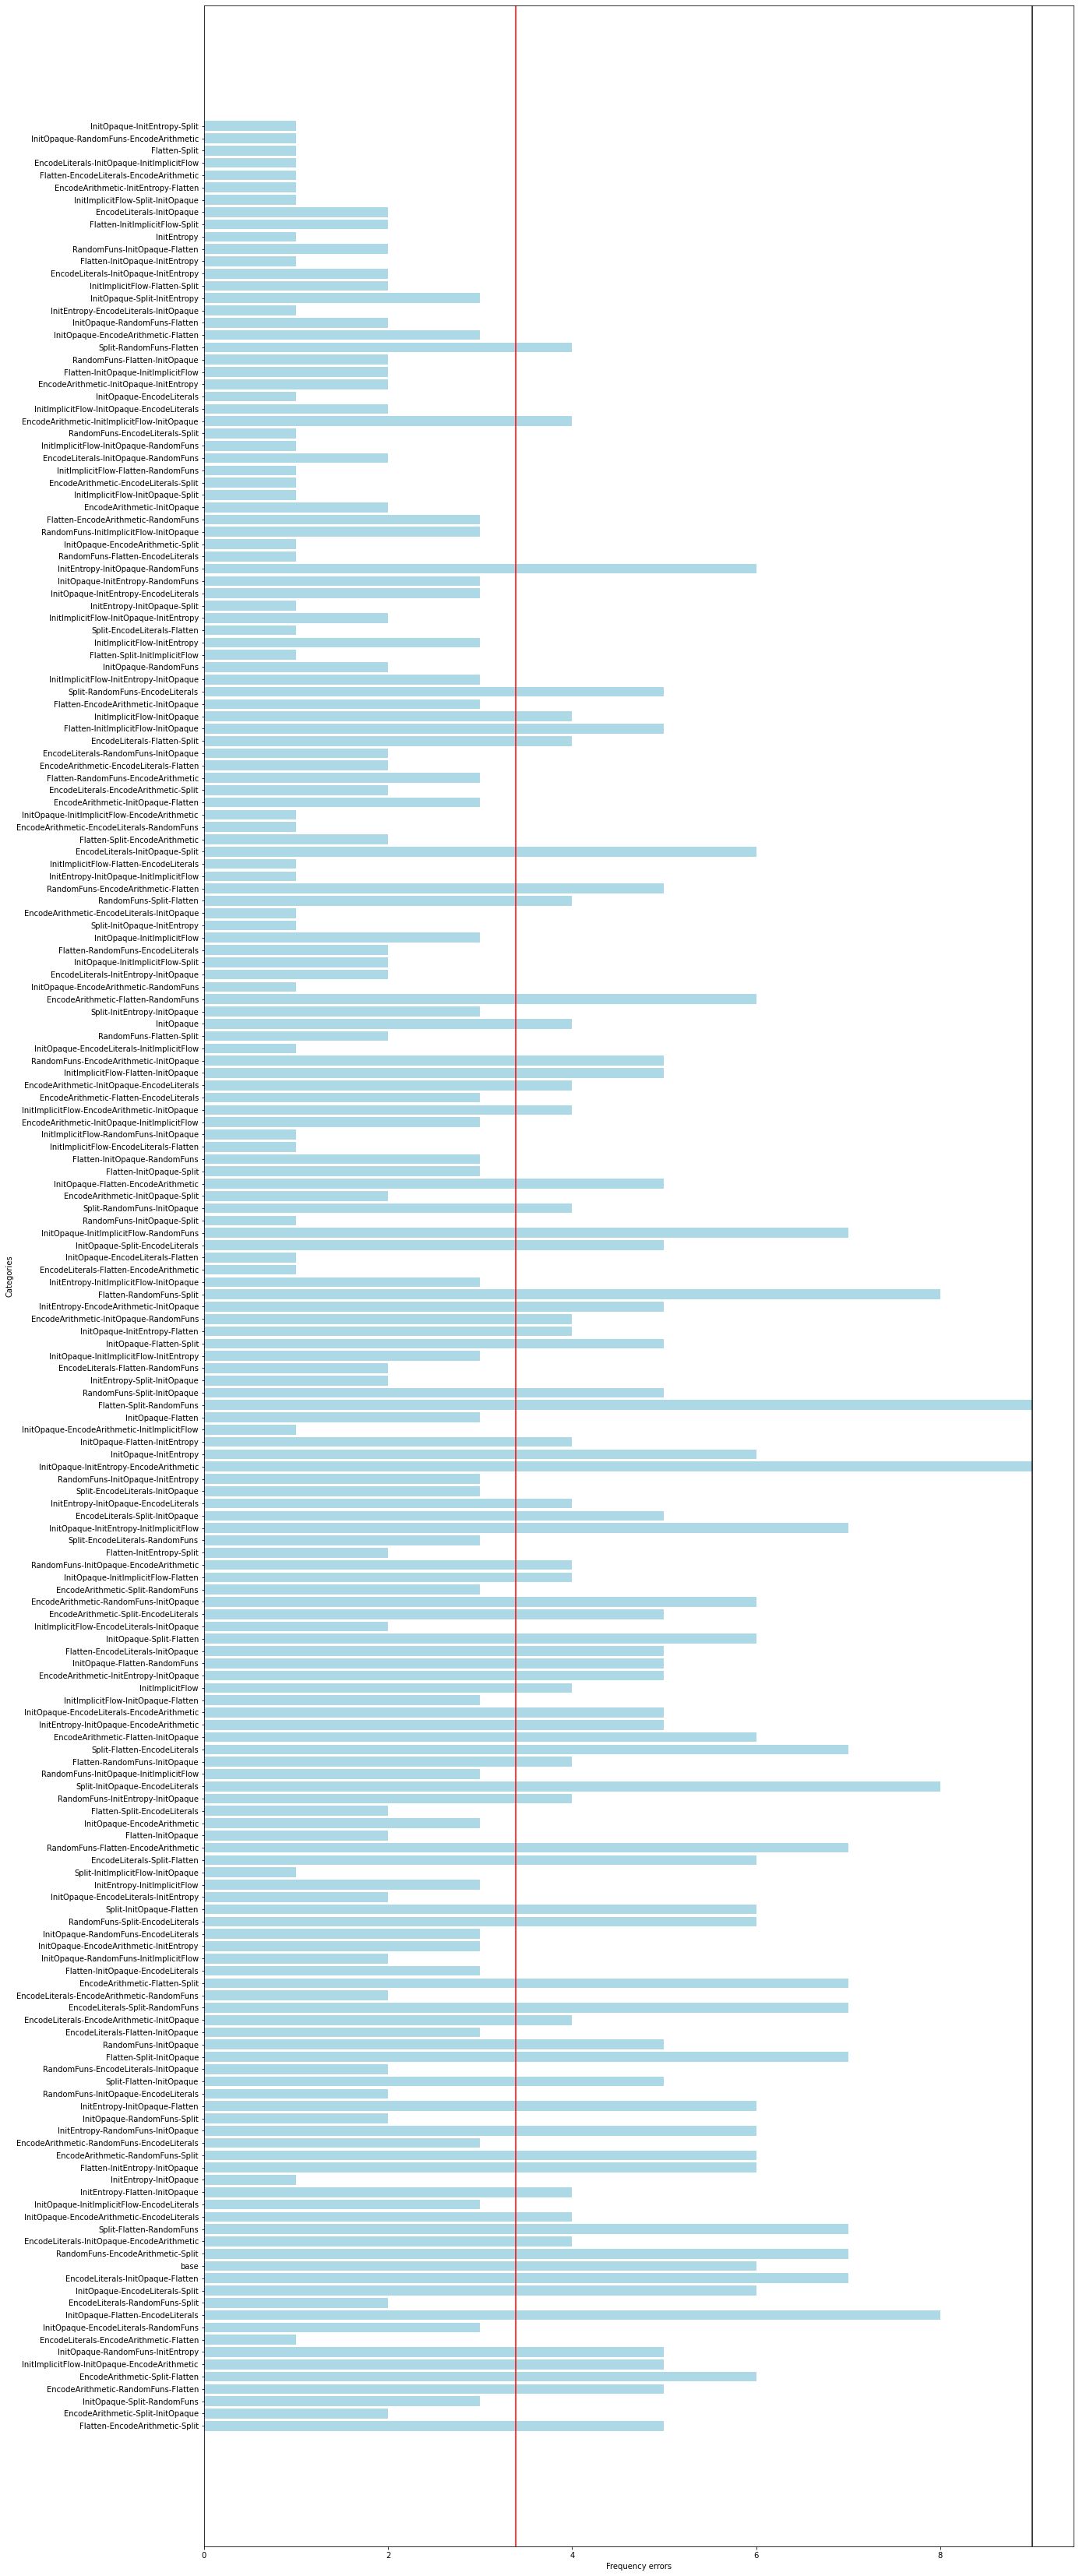

In [110]:
plt.figure(figsize=(20, 60))

plt.barh(list(count_obf_err.keys()), list(count_obf_err.values()), color="lightblue")

plt.axvline(np.asarray(list(count_obf_err.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(count_obf_err.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(count_obf_err.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()

In [111]:
'''
plt.figure(figsize=(150,50))
plt.bar(list(count_obf_err.keys()), list(count_obf_err.values()), color="lightblue")
plt.axhline(np.asarray(list(count_obf_err.values())).mean(), color="red") # Horizontal line adding the threshold
plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()
'''

'\nplt.figure(figsize=(150,50))\nplt.bar(list(count_obf_err.keys()), list(count_obf_err.values()), color="lightblue")\nplt.axhline(np.asarray(list(count_obf_err.values())).mean(), color="red") # Horizontal line adding the threshold\nplt.xlabel("Frequency errors") # x label\nplt.ylabel("Categories") # y label\nplt.show()\n'

In [112]:
#print(wrong_obf)

Stampa per singolo offuscamento erroneo.

Non tutti gli offuscamenti sono applicati lo stesso numero di volte, quindi il grafico non ha fedeltà.

In [113]:
#plt.figure(figsize=(10, 10));
#plt.barh(list(count_single_obf.keys()), list(count_single_obf.values()), color = "lightgreen");

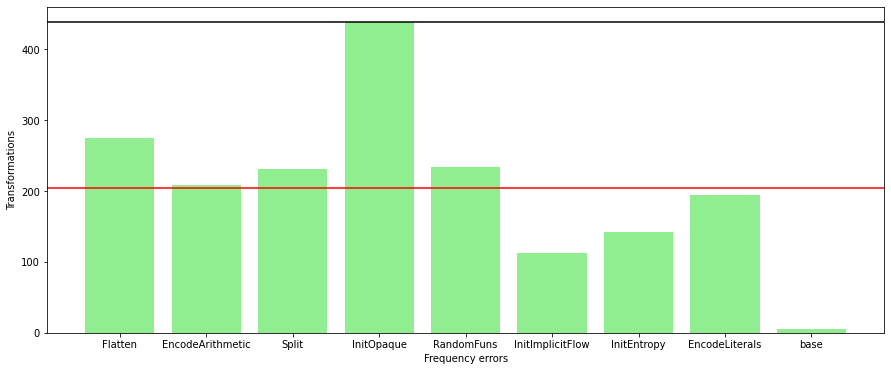

In [114]:
#count_single_obf_dict = dict(count_single_obf)

plt.figure(figsize=(15, 6))
#np.asarray(list(count_single_obf.values())).mean()
#np.asarray(list(count_single_obf.values())).median()
plt.bar(list(count_single_obf.keys()), list(count_single_obf.values()), color="lightgreen")
plt.axhline(np.asarray(list(count_single_obf.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axhline(np.asarray(list(count_single_obf.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axhline(np.asarray(list(count_single_obf.values())).max(), color="black") # Horizontal line adding the threshold
plt.xlabel("Frequency errors") # x label
plt.ylabel("Transformations") # y label
plt.show()

In [141]:
#Ordina e ritorna una lista
count_ordered_single_obfs_list = count_ordered_single_obfs.most_common()

In [134]:
'''
plt.figure(figsize=(20, 20))

plt.barh(list(count_ordered_single_obfs.keys()), list(count_ordered_single_obfs.values()), color="lightblue")

plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()
'''

'\nplt.figure(figsize=(20, 20))\n\nplt.barh(list(count_ordered_single_obfs.keys()), list(count_ordered_single_obfs.values()), color="lightblue")\n\nplt.axvline(np.asarray(list(count_ordered_single_obfs.values())).mean(), color="red") # Horizontal line adding the threshold\n#plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).std(), color="grey") # Horizontal line adding the threshold\nplt.axvline(np.asarray(list(count_ordered_single_obfs.values())).max(), color="black") # Horizontal line adding the threshold\n\nplt.xlabel("Frequency errors") # x label\nplt.ylabel("Categories") # y label\nplt.show()\n'

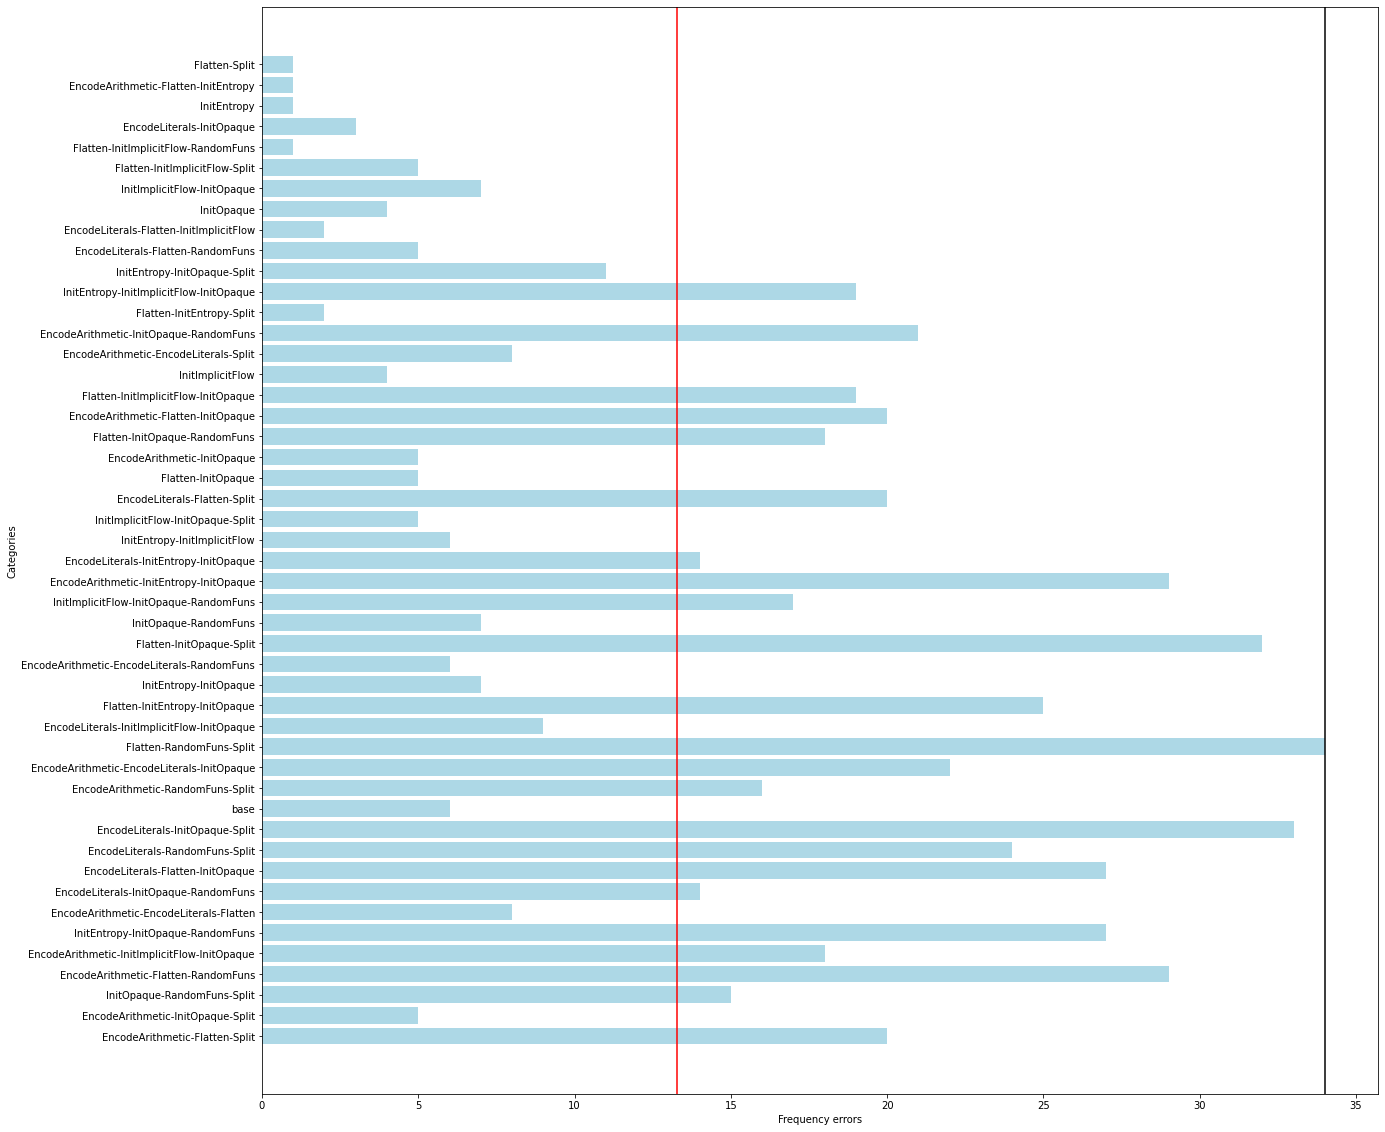

In [147]:
plt.figure(figsize=(20, 20))

plt.barh(list(count_ordered_single_obfs.keys()), list(count_ordered_single_obfs.values()), color="lightblue")

plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).mean(), color="red") # Horizontal line adding the threshold
#plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).std(), color="grey") # Horizontal line adding the threshold
plt.axvline(np.asarray(list(count_ordered_single_obfs.values())).max(), color="black") # Horizontal line adding the threshold

plt.xlabel("Frequency errors") # x label
plt.ylabel("Categories") # y label
plt.show()